Alexander S. Lundervold, September 23rd, 2018

# Introduction

In this part of the course we start digging into some details about how machine learning models work. How some of the main models are constructed, and how they are trained on data. 

We'll cover the following topics in this notebook:
- **Linear regression**. A very basic model, but frequently used in both industry and academia. You've likely seen it before in your maths classes. This model is so simple that you actually don't have to train it to make it produce something optimal. We can essentially "solve" the model to find the exact optimal solution (at least if we disregard restrictions caused by memory requirements, as we'll see). However, we'll see how the model can be trained using **gradient descent**.


- **Gradient descent**. This is one of the most important training algorithms in modern machine learning! It's most famously used in neural networks and deep learning, but it's actually a simple(!) optimization approach that can be used for many other models. 

See also Geron's notebook here: https://github.com/ageron/handson-ml/blob/master/04_training_linear_models.ipynb

# Setup

We set up our standard environment below.

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Linear regression

You've probably seen linear regression before: it's a simple way to fit a straight line through a set of data points. In fact, you looked at it already in "videregående skole" (high school):

<img src="assets/linreg_book.png"><br>
                <span><center><small>Image from <a href="http://sinus-1t.cappelendamm.no/elevreal/videosamling.html?tid=1965498&sec_tid=1363315">Sinus 1T</a></small></center></span>

Remember that the equation for a straight line in two dimensions is 
$$y = ax + b.$$ 

We will make us of straight lines in _any_ dimensional space – not just in two dimensions – and we'll therefore change the notation a bit to make it more convenient. We'll write

$$y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$$

where the $\theta_i$ are numbers (the **model parameters**) and the $x_i$ are variables (the **feature values**). We get back the above two-dimensional case by setting $\theta_0 = b$ and $\theta_1 = a$ and all the other $\theta_i$'s to zero.

If you remember your linear algebra, you'll notice that if we collect all the parameters in a **parameter vector** $\theta = [\theta_0, \theta_1, \dots, \theta_n]$ and the features in a **feature vector** $\mathbf{x} = [x_0, x_1, \dots, x_n]$, where $x_0 = 1$, then we can write

$$y = \theta \cdot \mathbf{x},$$

where $\cdot$ is the dot product (also called the scalar product or the inner product). 

> Have a look at [Khan Academy: Vector dot product and vector length](https://nb.khanacademy.org/math/linear-algebra/vectors-and-spaces/dot-cross-products/v/vector-dot-product-and-vector-length) if you want a refresher.

Let's try it out in code. First we need some data. We'll generate a bunch of points from a linear function, but add some noise to the points to make them deviate from a straight line.

In [4]:
np.random.seed(seed)
m = 100
X = 2 * np.random.rand(m, 1) # m random numbers between 0 and 2
# y-value generated by the function with theta_0 = 4, theta_1 = 3, and some noise:
y = 4 + 3 * X + np.random.randn(m, 1) 

Here they are:

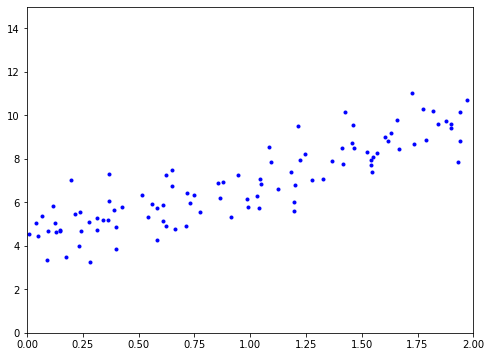

In [5]:
plt.figure(figsize=(8,6))
plt.plot(X,y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

> Our goal is to find the "best" straight line that goes through all the points.

This is the result we're after:

<img src="assets/regression_line.png">

Let's write 
$$\hat{y}(x) = \theta_0x_0 + \theta_1 x_1 = \theta \cdot \mathbf{x}, \qquad \mbox{where} \quad x_0 = 1$$
for the straight line we'll try to fit to the data.

First we need to define what we mean by *best*. A sensible measure for how well a line fits the data is the sum of the distance from the line and the data, calculated using the euclidean metric $|x_n - \hat{y}(x_n)|$. Note that other ways to measure distances (i.e. other metrics) are possible.

It turns out to be convenient to minimize the so-called **mean square error** (MSE):

$$\begin{align}\mbox{MSE}(\theta) &= \frac1m \sum_{i=1}^m \big(\theta \cdot \mathbf{x}^{(i)} - y^{(i)} \big)^2\\
\end{align}$$

(and, sometimes, the **root mean square error** (RMSE), which is simply $\sqrt{\mbox{MSE}(\theta)}$.) Here $\mathbf{x}^{(i)}$ and $y^{(i)}$ represent the i-th data point.

In code:

In [6]:
def MSE(theta0, theta1):
    """
    Mean square error for linear regression
    """
    error = 0
    for xi, yi in zip(X,y):
        yhat = theta0 + theta1*xi
        error += (yhat - yi)**2
    return error/len(X)

Here's the mean squared error when using the line $\hat{y} = 1 + 12x$ to fit our data:

In [7]:
MSE(1,12)

array([60.521481])

Here it is for $\hat{y} = 3 + 5x$:

In [8]:
MSE(3,5)

array([3.326786])

You can play around with selecting values for $\theta_0$ and $\theta_1$ below. What combination of $\theta_1$ and $\theta_2$ do you expect will give the best result?

In [9]:
from ipywidgets import interact

_ = interact(MSE, theta0=(-5,5), theta1=(-5,5))

interactive(children=(IntSlider(value=0, description='theta0', max=5, min=-5), IntSlider(value=0, description=…

> **Your turn!**
Try to calculate the MSE by hand if you use the line $\frac12 + \frac14 x$ as a model to fit the three data points 

$$\mathbf{x}^{(1)} = (1,1) \qquad \mathbf{x}^{(2)} = (2,1) \qquad \mathbf{x}^{(3)} = (4,2)$$

In machine learning, the functions we're trying to minimize when training models are called **error functions**, **cost functions**, **objective function** or **loss functions**.

In fact, you can compute this result _exactly_ by using MAT108 techniques: differentiate the MSE function with respect to $\theta$, and solve for $\theta$ when setting the derivative to zero. The solution, called the **normal equation**, gives the exact values for $\theta$ that are best. See the tectbook for more details. 

We'll rather try to get there using **gradient descent**, a hugely powerful (but very simple) algorithm that can be used to optimize any function, way beyond simple linear regression. 

> In general, **optimization** refers to the task of finding the minimum or maximum of a function $f(\mathbf{x})$ by altering the variable $\mathbf{x}$. In our case, we want to find the minimum of $MSE(\theta)$ by altering $\theta$.

> One can in principle find the minimum of any differentiable function by finding all the points that have derivative equal zero, but in practice this is not a good way to do it! (For example, in artificial neural networks there are typically thousands, and in deep learning often millions of parameters, and we would have to solve million-degree equations). 

# Gradient descent

To train a machine learning model means to find the model parameters that best describe the training data, where "best" refers to minimizing the cost function. 

One very general algorithm that achieves this is **gradient descent**, an iterative optimization algorithm that seeks to find the model parameters that minimize a given cost function.

Remember (from MAT108 or from high school) that the derivative of a function can tell you where it is increasing and decreasing. Think of the following example, where we have a function of one variable:

<img src="assets/tangent.gif">

For functions of more than one variable the so-called **gradient**, written as $\nabla f$, plays the role of the derivative (you need something more than the standard derivative when you have more than just one variable $x$ in $y=f(x)$, because there are several "x's" to differentiate with respect to). Have a look at [Khan Academy's "Derivatives of multivariable functions"](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives) for a refresher.

> Importantly, **the gradient $\nabla$ of $f$ always points in the direction where $f$ increases the most**. This is true in *any* dimension.

<img src="assets/gradient.gif">

This gives us a simple way to find the minimum of a cost function: start with some random parameters $\theta$. Calculate the gradient of the cost function at $\theta$. Take a small step in the direction *opposite* of the gradient. Repeat this. This is called **gradient descent**, and dates back to the work of the mathematician Louis Augustin Cauchy in 1847 (motivated by calculations in astronomy).

<img src="assets/graddesc-mountain.png">

Visually, what we're doing when using gradient descent for linear regression is the following (only in higher dimensions):

<img src="assets/graddesc.png"><br><small><center>Image from A. Géron</center></small>

<img src="assets/gradient_descent.gif"> <br><small><center>Image from <a href="https://alykhantejani.github.io/a-brief-introduction-to-gradient-descent/">Alykhan Tejani</a></center></small>

Algorithmically, we're doing

$$\theta = \theta - \eta \nabla \mbox{MSE}(\theta),$$

where $\eta$ (greek letter "eta") is our step-size, also called the **learning rate**.

To implement this algorithm we need a way to calculate (or estimate) the gradient of the cost function with respect to the parameters $\theta$. 

Luckily, mean square error is such an easy function and calculating the gradient directly is not hard. It involves a bit of vector calculus which may be unfamiliar to you, but, believe me, if you reformulate MSE as

$$\mbox{MSE}(\theta) =\frac 1m (\mathbf{X} \theta - y)^T (\mathbf{X} \theta - y)$$

where $\mathbf{X}$ is the so-called **design matrix** containing all the training examples
$$\mathbf{X} =  \left(\begin{array}{l} \mathbf{x}^{(1)} \\ \mathbf{x}^{(1)} \\ \vdots \\ \mathbf{x}^{(m)}\end{array}\right),$$ then a small calulation results in 

$$ \nabla \mbox{MSE}(\theta) = \frac2m \mathbf{X}^T (\mathbf{X} \cdot \theta - \mathbf{y})$$

Let's try it out!

## Gradient descent example

Since we want to use the formula $\hat{y} = \theta \cdot \mathbf{x}$ as above, we need to add the $x_0 = 1$ to our previous $X$:

In [10]:
X_b = np.c_[np.ones((m,1)), X]

In [11]:
eta = 0.01
n_epochs = 500 # We'll go through the training data many times. One pass through is called an epoch.

In [12]:
np.random.seed(seed)
theta = np.random.randn(2,1) # We start with some random parameters

In [13]:
theta

array([[ 0.49671415],
       [-0.1382643 ]])

In [14]:
for epoch in range(n_epochs):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

In [15]:
theta

array([[4.09699856],
       [2.87438714]])

We've now trained our model on the training set $X$ using gradient descent. After training, the model thinks that $\theta_1=4.1$ and $\theta_1 = 2.87$ are good parameter choices.

We can use it to make predictions on a new test data set:

In [16]:
X_new = np.array([[0], [2]]) # We choose two x-values
X_new_b = np.c_[np.ones((2,1)), X_new] # Again, we need to add x0 = 1

In [17]:
y_predict = X_new_b.dot(theta) # We predict the corresponding y-values using the theta found during training
y_predict

array([[4.09699856],
       [9.84577284]])

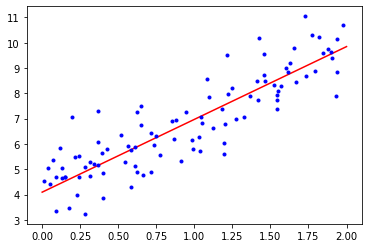

In [18]:
plt.plot(X_new, y_predict, 'r')
plt.plot(X, y, 'b.')
plt.show()

Not bad!

Let's animate the model during training, step for step. Note: it's not necessary to study the code used to create the animation.

In [19]:
from matplotlib import animation, rc
from IPython.display import HTML

def animatePred(eta=0.01, n_epochs = 500): 
    # Calculate predictions
    np.random.seed(seed)
    theta = np.random.randn(2,1)  # Random initialization
    thetas = [theta, ]

    for epoch in range(n_epochs):
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta*gradients
        thetas.append(theta)   
        
    # Plot results
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(X, y, "b.")  
    y_predict_grad = X_new_b.dot(thetas[0])
    line, = ax.plot(X_new, y_predict_grad)
    text = ax.text(0.5, 0.5, '')
    def animate(i):
        y_predict_grad = X_new_b.dot(thetas[i])
        line.set_ydata(y_predict_grad)  # update the data
        text.set_text('theta0 = %.2f\n theta1 = %.2f' % (thetas[i][0], thetas[i][1]))
        return line,
    
    #Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(X_new, mask=True))
        return line,
    
    ani = animation.FuncAnimation(fig, animate, init_func=init,
        interval=30, blit=True)
    
    HTML(ani.to_html5_video())
    rc('animation', html='html5')
    return ani

In [20]:
%%capture
anim = animatePred()

In [21]:
anim.save('assets/gradDescent_anim_1.mp4')

In [22]:
%%HTML
<video width=100% controls autoplay loop>
    <source src="./assets/gradDescent_anim_1.mp4" type="video/mp4">
</video>

## What can go wrong?

Note that in the above gradient descent implementation we chose two things: the learning rate and the number of iterations. Both of these can lead to trouble if not chosen carefully, especially in more complex models (like neural networks, for example). 

### Effect of choosing learning rates and number of epochs

We can experiment with this using an interactive visualization of gradient descent for the data generated above:

In [23]:
from ipywidgets import interact, interactive, FloatSlider, IntSlider

In [24]:
def generate_plot_gradient_descent(eta, n_epochs):
    np.random.seed(seed)
    theta = np.random.randn(2,1)
    plt.figure(1, figsize=(8,6))
    for epoch in range(n_epochs):
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta*gradients
    
    y_predict = X_new_b.dot(theta)
    plt.plot(X_new, y_predict, 'r')
    plt.plot(X, y, 'b.')
    plt.show()
    
interactive_plot = interactive(generate_plot_gradient_descent, 
                               eta = FloatSlider(min=0.001, max=1.0, step=0.005, value=0.1), 
                               n_epochs=IntSlider(min=2, max=50, step=10, value=20))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.1, description='eta', max=1.0, min=0.001, step=0.005), IntSlider(val…

Here are some animations to help you see what's going on:

In [25]:
%%capture
ani_001 = animatePred(eta=0.01, n_epochs=500)
ani_002 = animatePred(eta=0.02, n_epochs=500)
ani_01 = animatePred(eta=0.1, n_epochs=500)
ani_05 = animatePred(eta=0.5, n_epochs=500)

In [26]:
ani_001.save('./assets/ani_001.mp4')
ani_002.save('./assets/ani_002.mp4')
ani_01.save('./assets/ani_01.mp4')
ani_05.save('./assets/ani_05.mp4')

In [27]:
%%HTML
<video width=100% controls autoplay loop>
    <source src='./assets/ani_01.mp4' type="video/mp4">  # Change file to watch the others
</video>

We notice that, unsurprisingly, very low learning rates lead to very slow convergence. Also, very high learning rates leads to something that doesn't converge at all! Why is that?

<img src="assets/smalllr.png"> <img src="assets/biglr.png">

> **Your turn!**
- Use **grid search** to find a good learning rate for a fixed number of epochs. Set `n_epochs=100` and search through a set of learning rates for the one that results in the lowest cost for that number of epochs.

### What if there are several local minimums?

For linear regression, the mean square error function is *convex*, which means that there is one, and only one minimum. This is not the case in general. Very few functions are convex, most have several local minimas. 

<img src="assets/localoptimum.png">

In fact, this is one of the main reasons why artificial neural networks are so tricky to train: their cost functions are convex functions of the parameters. However, it has recently turned out that minor variations of gradient descent still works great, even for deep neural networks (i.e. deep learning), as long as you have enough computing power (i.e. powerful GPUs or TPUs). 

We'll discuss these variants of gradient descent next.

# Variants of gradient descent

These are three main ways of doing gradient descent, each with some advantages and disadvantages:

- In **batch gradient descent** the entire training data set is fed to the algorithm each time the gradient is calculated. Each step is therefore carefully chosen, but we have to be able to store the entire training data set in memory. Which is often way beyond what's possible, as we often can have very large data points (think images) or millions of smaller ones. 


- **Stochastic gradient descent** is the opposite extreme: the update of the parameter $\theta$ is done based on calculating the gradient for *one single data point* each time, chosen at random. This results in highly random updates, but has the advantage of being online: we can train the model on the fly as new data arrives. In addition, the randomness in stochastic gradient descent can allow us to escape local minimas, because a point where the cost function has derivative zero with respect to the entire data set will typically not have derivative zero when considering one point at a time.


- **Mini-batch gradient descent** is a compromise between these extremes. The updates are made based on a few examples, called a batch. This is the approach taken when training artificial neural networks, where the batch size is typically set as high as the GPU memory can handle. This allows for more parallelization, something GPUs excel at. <br><br><img width=30% src="assets/gpu.png">

Note that people often say stochastic gradient descent when they are referring to mini-batch gradient descent. 

There are other slightly more advanced variations of gradient descent out there, that takes into account previous gradients when computing the next update (search for RMSProp, Adagrad or Adam optimizer if you're curious). We'll use these when we get to the deep learning part of the course.

Let's try out the three main versions of gradient descent for our linear regression problem.

## In psuedocode

```
for epoch in range(num_epochs): 
  gradient = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * gradient
  
  
for epoch in range(num_epochs):
  for i in range(len(data)):
    example = random.choice(data)
    gradient = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * gradient
    
    
for epoch in range(num_epochs):
  for batch in get_random_batches(data):
    gradient = evaluate_gradient(loss_function, batch, params)
    params = params - learning_rate * gradient
```

## The `evaluate_gradient` function

We've already calculated the gradient of MSE with respect to the parameters $\theta$ in linear regression, and can use it to create the `evaluate_gradient` function:

In [28]:
def evaluate_gradient(x, theta, y):
    m = len(X)
    return 2/m * x.T.dot(x.dot(theta) - y)

For convenience, we create a function to plot the regression line on top of our data:

In [29]:
def plot_result(theta):
    y_predict = X_new_b.dot(theta)
    plt.plot(X_new, y_predict, 'r')
    plt.plot(X, y, 'b.')
    plt.show()

## Batch gradient descent

This is what we did earlier:

In [30]:
eta = 0.001 # learnng rate
n_epochs = 1000

theta = np.random.randn(2,1) # Random initalization of the parameters

for epoch in range(n_epochs):
    gradients = evaluate_gradient(X_b, theta, y)
    theta = theta - eta*gradients
    
print(theta)

[[3.19337239]
 [3.60213102]]


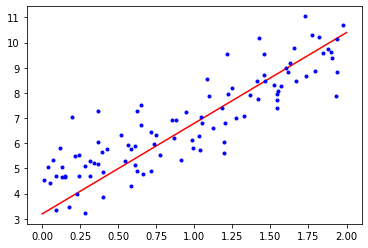

In [31]:
plot_result(theta)

## Stochastic gradient descent

In [32]:
eta = 0.001
n_epochs = 1000

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(len(X_b)):
        random_index = np.random.randint(len(X_b)) # Need this to fetch both an x and corresponding y
        xi = X_b[random_index:random_index+1]
        yi = y[random_index]
        gradients = evaluate_gradient(xi, theta, yi)
        theta = theta - eta*gradients
    
print(theta)

[[3.43156653]
 [3.34420005]]


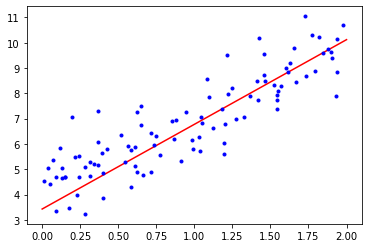

In [33]:
plot_result(theta)

Since stochastic gradient descent is very erratic one usually use some form of learning rate decay to stop it from jumping out of good minima. The idea is that as the cost approaches a minimum, the steps should get shorter and shorter to make the algorithm settle at the minimum.

We can do this by creating a simple learning rate schedule. Say we want to start the learning rate at 0.01, and gradually decay it towards zero as we go through the training data. 

Here's one way to do it:

In [34]:
def lr_schedule(alpha, iteration):
    """
    Decays an initial learning rate for each iteration
    """
    
    return 1./ (alpha * (iteration + 100))

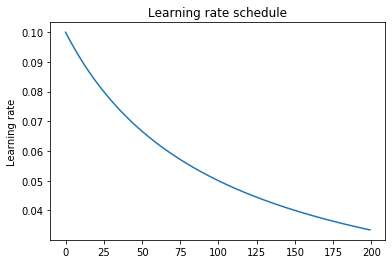

In [35]:
t = np.arange(0.0, 200.0)
plt.plot(lr_schedule(0.1, t))
plt.title("Learning rate schedule")
plt.ylabel("Learning rate")
plt.show()

**Note that this gives us another hyperparameter to tune** when training our models (the alpha).

In [36]:
eta = 0.001
n_epochs = 500
alpha = 0.1

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(len(X_b)):
        random_index = np.random.randint(len(X_b)) # Need this to fetch both an x and corresponding y
        xi = X_b[random_index:random_index+1]
        yi = y[random_index]
        eta = lr_schedule(alpha, i)
        gradients = evaluate_gradient(xi, theta, yi)
        theta = theta - eta*gradients
    
print(theta)

[[4.22047503]
 [2.79947459]]


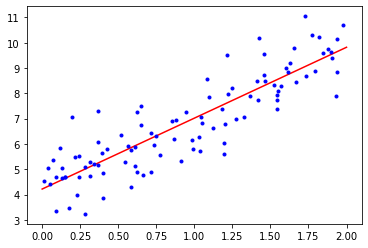

In [37]:
plot_result(theta)

## Mini-batch gradient descent

In [38]:
n_epochs = 500
minibatch_size = 20
alpha = 0.01

theta = np.random.randn(2,1)  # random initialization


for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(len(X_b))
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, len(X_b), minibatch_size):
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = evaluate_gradient(xi, theta, yi)
        eta = lr_schedule(alpha, i)
        theta = theta - eta * gradients

In [39]:
theta

array([[4.26780674],
       [2.82017325]])

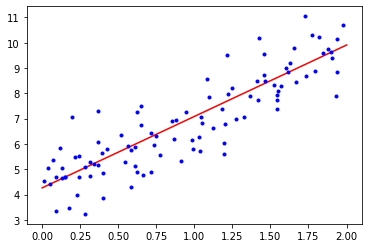

In [40]:
plot_result(theta)

## Comparison

Here's an illustration showing how the three variants of gradient descent above approaches the solution:

<img src="assets/grad_descent_comparisons.png">

*The above image is created by a slight modification of code in the book. See the file `grad_descent_comparison.py` for the code.*

In [41]:
# %load grad_descent_comparison.py

# Linear regression and gradient descent in scikit-learn

Of course, in practice you wouldn't implement linear regression and gradient descent by hand as we did above. You'll use highly efficient and robust implementations from a well-established library. Like scikit-learn. 

## Linear regression

In [42]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
theta = [lin_reg.intercept_, lin_reg.coef_]

In [44]:
theta

[array([4.21509616]), array([[2.77011339]])]

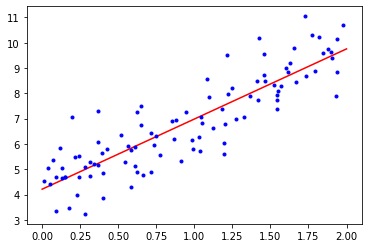

In [45]:
plot_result(theta)

Note that we used `X` instead of `X_b` in `lin_reg.fit`. The bias term is taken care of automatically by scikit-learn's `LinearRegression`.

In [46]:
y_train_pred = lin_reg.predict(X)

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
mean_squared_error(y, y_train_pred)

0.8065845639670534

## Gradient descent

The <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor">SGDRegressor</a> in scikit-learn implements stochastic gradient descent.

In [49]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(loss='squared_loss', penalty='none', alpha=0.1, 
                       learning_rate='optimal', max_iter=1000)

sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='optimal', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='none', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

> I chose the above parameters for `SGDRegressor` to make it fit better with what we did manually above (MSE loss, the fact that we did no regularization, and our learning rate scheduler).

In [50]:
theta = [sgd_reg.intercept_, sgd_reg.coef_]

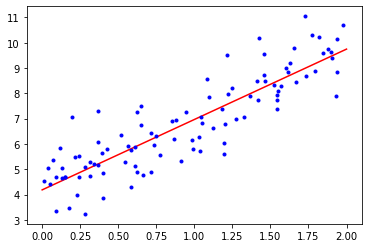

In [51]:
plot_result(theta)

In [52]:
y_train_pred = sgd_reg.predict(X)

In [53]:
mean_squared_error(y, y_train_pred)

0.8069644848673899